# MVP and HRP Portfolio Design for NIFTY 50  Stocks


<a id='1'></a>
## 1. Loading the Data and Python Libraries

<a id='1.1'></a>
### 1.1. Loading the Python Libraries

In [6]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

#Import Model Packages 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers


<a id='1.2'></a>
### 1.2. Loading the Data

In [7]:
# load dataset
dataset = read_csv('NIFTY_50.csv',index_col=0)

In [8]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [9]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
## 2. Exploratory Data Analysis

In [10]:
# shape
dataset.shape

(1482, 50)

In [11]:
# peek at data
set_option('display.width', 100)
dataset.head()

ADANIPORTS  ASIANPAINT    AXISBANK   BAJAJ-AUTO  BAJFINANCE   BAJAJFINSV  BHARTIARTL  \
date                                                                                               
01-01-2016  267.549988  878.750000  449.899994  2518.000000  609.585022  1983.800049  312.639740   
04-01-2016  257.950012  880.799988  438.399994  2483.350098  605.244995  1959.500000  300.060699   
05-01-2016  255.699997  900.650024  436.450012  2502.350098  599.784973  1946.000000  296.984802   
06-01-2016  251.800003  886.400024  430.700012  2485.500000  610.724976  1938.550049  295.837067   
07-01-2016  245.000000  872.349976  409.250000  2419.250000  610.630005  1927.050049  295.974792   

                  BPCL    BRITANNIA       CIPLA  ...   SUNPHARMA  TATAMOTORS   TATASTEEL  \
date                                             ...                                       
01-01-2016  298.683319  1493.199951  655.349976  ...  815.549988  401.899994  245.234406   
04-01-2016  297.149994  1486.300049  645.650024  ...  799.099976  377.049988  244.758041   
05-01-2016  300.883331  1483.349976  640.849976  ...  800.500000  374.450012  261.335663   
06-01-2016  304.100006  1500.849976  652.099976  ...  791.950012  365.899994  256.047974   
07-01-2016  294.750000  1473.275024  637.450012  ...  783.799988  343.549988  238.088882   

                    TCS  TATACONSUM       TECHM       TITAN   ULTRACEMCO         UPL       WIPRO  
date                                                                                              
01-01-2016  1208.199951  146.399994  520.049988  352.049988  2824.000000  293.566681  208.668808  
04-01-2016  1184.800049  143.699997  516.400024  351.399994  2749.149902  289.233337  209.137558  
05-01-2016  1174.474976  148.350006  521.900024  347.700012  2733.050049  290.200012  208.837555  
06-01-2016  1190.800049  145.250000  525.099976  347.850006  2735.300049  295.566681  208.162552  
07-01-2016  1185.625000  140.050003  510.799988  344.049988  2667.699951  278.266663  206.193802  

[5 rows x 50 columns]

<a id='3'></a>
## 3. Data Pre-processing

<a id='3.1'></a>
### 3.1. Data Cleaning
We check for the NAs in the rows, either drop them or fill them with the mean of the column.

In [12]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())
dataset.shape

Null Values = True


(1482, 50)

Getting rid of the columns with more than 30% missing values. 

In [13]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.4].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(1482, 50)

Given that there are null values drop the rown contianing the null values.

In [14]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')
dataset.head()

ADANIPORTS  ASIANPAINT    AXISBANK   BAJAJ-AUTO  BAJFINANCE   BAJAJFINSV  BHARTIARTL  \
date                                                                                               
01-01-2016  267.549988  878.750000  449.899994  2518.000000  609.585022  1983.800049  312.639740   
04-01-2016  257.950012  880.799988  438.399994  2483.350098  605.244995  1959.500000  300.060699   
05-01-2016  255.699997  900.650024  436.450012  2502.350098  599.784973  1946.000000  296.984802   
06-01-2016  251.800003  886.400024  430.700012  2485.500000  610.724976  1938.550049  295.837067   
07-01-2016  245.000000  872.349976  409.250000  2419.250000  610.630005  1927.050049  295.974792   

                  BPCL    BRITANNIA       CIPLA  ...   SUNPHARMA  TATAMOTORS   TATASTEEL  \
date                                             ...                                       
01-01-2016  298.683319  1493.199951  655.349976  ...  815.549988  401.899994  245.234406   
04-01-2016  297.149994  1486.300049  645.650024  ...  799.099976  377.049988  244.758041   
05-01-2016  300.883331  1483.349976  640.849976  ...  800.500000  374.450012  261.335663   
06-01-2016  304.100006  1500.849976  652.099976  ...  791.950012  365.899994  256.047974   
07-01-2016  294.750000  1473.275024  637.450012  ...  783.799988  343.549988  238.088882   

                    TCS  TATACONSUM       TECHM       TITAN   ULTRACEMCO         UPL       WIPRO  
date                                                                                              
01-01-2016  1208.199951  146.399994  520.049988  352.049988  2824.000000  293.566681  208.668808  
04-01-2016  1184.800049  143.699997  516.400024  351.399994  2749.149902  289.233337  209.137558  
05-01-2016  1174.474976  148.350006  521.900024  347.700012  2733.050049  290.200012  208.837555  
06-01-2016  1190.800049  145.250000  525.099976  347.850006  2735.300049  295.566681  208.162552  
07-01-2016  1185.625000  140.050003  510.799988  344.049988  2667.699951  278.266663  206.193802  

[5 rows x 50 columns]

<a id='3.2'></a>
### 3.2. Training and Test Dataset Preparation

For the purpose of clustering, we will be using annual return figures. Let us prepare the dataset for training and testing, by separating 83.30% of the records for training the models and remaining records for testing. These figures have been chosen in such a way that the records of the year 2021 go into the test dataset while other records remain in the training dataset.

In [15]:
X= dataset.copy('deep')
row= len(X)
train_len = int(row*.8330)

In [16]:
X_train = X.head(train_len)

In [17]:
X_train

ADANIPORTS   ASIANPAINT    AXISBANK   BAJAJ-AUTO   BAJFINANCE   BAJAJFINSV  \
date                                                                                     
01-01-2016  267.549988   878.750000  449.899994  2518.000000   609.585022  1983.800049   
04-01-2016  257.950012   880.799988  438.399994  2483.350098   605.244995  1959.500000   
05-01-2016  255.699997   900.650024  436.450012  2502.350098   599.784973  1946.000000   
06-01-2016  251.800003   886.400024  430.700012  2485.500000   610.724976  1938.550049   
07-01-2016  245.000000   872.349976  409.250000  2419.250000   610.630005  1927.050049   
...                ...          ...         ...          ...          ...          ...   
24-12-2020  478.549988  2648.250000  610.200012  3374.750000  5184.899902  8992.549805   
28-12-2020  483.549988  2683.899902  617.650024  3414.699951  5204.100098  8995.049805   
29-12-2020  483.399994  2696.800049  630.200012  3431.550049  5200.500000  8976.049805   
30-12-2020  485.399994  2734.399902  625.099976  3448.149902  5334.149902  8961.700195   
31-12-2020  483.750000  2764.500000  620.450012  3444.050049  5295.200195  8906.349609   

            BHARTIARTL        BPCL    BRITANNIA       CIPLA  ...   SUNPHARMA  TATAMOTORS  \
date                                                         ...                           
01-01-2016  312.639740  298.683319  1493.199951  655.349976  ...  815.549988  401.899994   
04-01-2016  300.060699  297.149994  1486.300049  645.650024  ...  799.099976  377.049988   
05-01-2016  296.984802  300.883331  1483.349976  640.849976  ...  800.500000  374.450012   
06-01-2016  295.837067  304.100006  1500.849976  652.099976  ...  791.950012  365.899994   
07-01-2016  295.974792  294.750000  1473.275024  637.450012  ...  783.799988  343.549988   
...                ...         ...          ...         ...  ...         ...         ...   
24-12-2020  517.299988  377.549988  3618.250000  833.200012  ...  590.450012  175.949997   
28-12-2020  521.599976  382.750000  3603.550049  830.150024  ...  586.950012  186.350006   
29-12-2020  520.250000  381.500000  3593.300049  827.950012  ...  590.599976  183.449997   
30-12-2020  516.150024  382.850006  3583.899902  823.799988  ...  584.000000  184.149994   
31-12-2020  509.700012  381.100006  3576.350098  819.950012  ...  592.349976  183.850006   

             TATASTEEL          TCS  TATACONSUM       TECHM        TITAN   ULTRACEMCO         UPL  \
date                                                                                                
01-01-2016  245.234406  1208.199951  146.399994  520.049988   352.049988  2824.000000  293.566681   
04-01-2016  244.758041  1184.800049  143.699997  516.400024   351.399994  2749.149902  289.233337   
05-01-2016  261.335663  1174.474976  148.350006  521.900024   347.700012  2733.050049  290.200012   
06-01-2016  256.047974  1190.800049  145.250000  525.099976   347.850006  2735.300049  295.566681   
07-01-2016  238.088882  1185.625000  140.050003  510.799988   344.049988  2667.699951  278.266663   
...                ...          ...         ...         ...          ...          ...         ...   
24-12-2020  622.299988  2909.350098  601.000000  947.250000  1495.900024  5044.750000  449.399994   
28-12-2020  632.650024  2929.399902  602.450012  947.099976  1543.550049  5142.149902  453.399994   
29-12-2020  632.200012  2930.500000  598.599976  965.650024  1540.099976  5146.750000  454.700012   
30-12-2020  640.450012  2909.300049  594.349976  983.250000  1552.599976  5354.750000  467.100006   
31-12-2020  643.650024  2862.750000  589.900024  973.200012  1567.150024  5288.149902  466.350006   

                 WIPRO  
date                    
01-01-2016  208.668808  
04-01-2016  209.137558  
05-01-2016  208.837555  
06-01-2016  208.162552  
07-01-2016  206.193802  
...                ...  
24-12-2020  382.200012  
28-12-2020  382.899994  
29-12-2020  385.000000  
30-12-2020  384.399994  
31-12-2020  386.250000  

[123

In [18]:
X_test = X.tail(row-train_len)

In [19]:
#Calculate percentage return 
returns = X_train.pct_change().dropna()
returns_test=X_test.pct_change().dropna()

The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms.

<a id='4'></a>
## 4. Evaluate the Models

<a id='4.1'></a>
### 4.1. Building Dendrogram for the HRP Model

The first step is to look for clusters of correlated stcoks using the agglomerate hierarchical clustering technique. The hierarchy class
has a dendrogram method which takes the value returned by the linkage method of
the same class.

Linkage does the actual clustering in one line of code, and returns a list of the clusters joined in the format: Z=[stock_1, stock_2, distance, sample_count]

#### Correlation Computation

In [20]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [21]:
#Calulate linkage
dist = correlDist(returns.corr())
link = linkage(dist, 'ward')
link[0]

array([4.        , 5.        , 0.42453942, 2.        ])

Computation of linkages is followed by the visualization of the clusters through a dendrogram, which displays a cluster tree.
The leaves are the individual stocks and the root represents the final single cluster. The “distance” between each cluster is shown along the y-axis, and thus the longer the branches indicate less correlated clusters of stcoks.

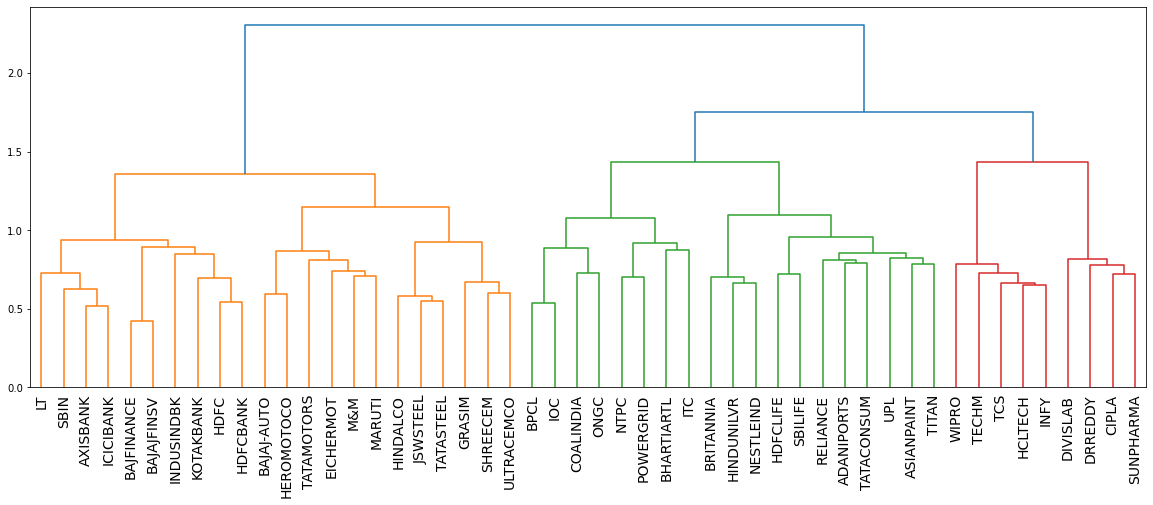

In [22]:
#Plot Dendogram
plt.figure(figsize=(20, 7))
#plt.title("Dendrograms")
dendrogram(link,labels = X.columns, leaf_font_size=14)
plt.show()

<a id='4.2'></a>
### 4.2 Steps involved in the HRP Model Design 

#### Quasi-Diagonalization and Weights Computation for HRP


Quasi-diagonalization is a matrix seriation process used in hierarchical clustering. The process involves reorganizing the covariance matrix of returns in such a way that stocks with similar returns are placed together. This matrix diagonalization allows us to distribute weights optimally following an inverse-variance allocation. For more details refer to Chapter 4 of the book.

In [23]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

#### Recursive Bisection

This step distributes the weights through recursive bisection based on the cluster covariance.

In [24]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar



def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

#### Comparison of HRP with MVP

So, in this step, python functions are defined for comparing the following two portfolio design approaches.

    1. MVP - Markowitz’s Minimum-Variance Portfolio
    2. HRP - Hierarchial Risk Parity

In [25]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #plt.figure(figsize=(20, 10))
    #dn = sch.dendrogram(link, labels=cov.index.values)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

#### Computation of the Weight Allocation for the Portfolios

In [26]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    portfolios = pd.DataFrame([mvp, hrp], index=['MVP', 'HRP']).T
    #portfolios = pd.DataFrame([ivp, hrp], index=['IVP', 'HRP']).T
    return portfolios

In [27]:
portfolios = get_all_portfolios(returns)
print(portfolios)

                 MVP       HRP
ADANIPORTS  0.001280  0.015945
ASIANPAINT  0.065688  0.027972
AXISBANK    0.000273  0.011698
BAJAJ-AUTO  0.006925  0.015379
BAJFINANCE  0.000318  0.006853
BAJAJFINSV  0.000357  0.014210
BHARTIARTL  0.006450  0.028246
BPCL        0.000447  0.015430
BRITANNIA   0.015312  0.026139
CIPLA       0.060079  0.024120
COALINDIA   0.050365  0.020939
DIVISLAB    0.008565  0.031135
DRREDDY     0.090809  0.024651
EICHERMOT   0.002411  0.010565
GRASIM      0.000321  0.010635
HCLTECH     0.007519  0.021270
HDFC        0.000752  0.018846
HDFCBANK    0.059241  0.019648
HDFCLIFE    0.001152  0.025079
HEROMOTOCO  0.000888  0.010995
HINDALCO    0.000219  0.011261
HINDUNILVR  0.067221  0.039964
ICICIBANK   0.000355  0.009448
INDUSINDBK  0.000219  0.009313
INFY        0.011781  0.020645
IOC         0.005523  0.017981
ITC         0.070645  0.039436
JSWSTEEL    0.000273  0.012502
KOTAKBANK   0.001393  0.013548
LT          0.001191  0.014905
M&M         0.000539  0.010392
MARUTI  

Text(0.5, 1.0, 'HRP')

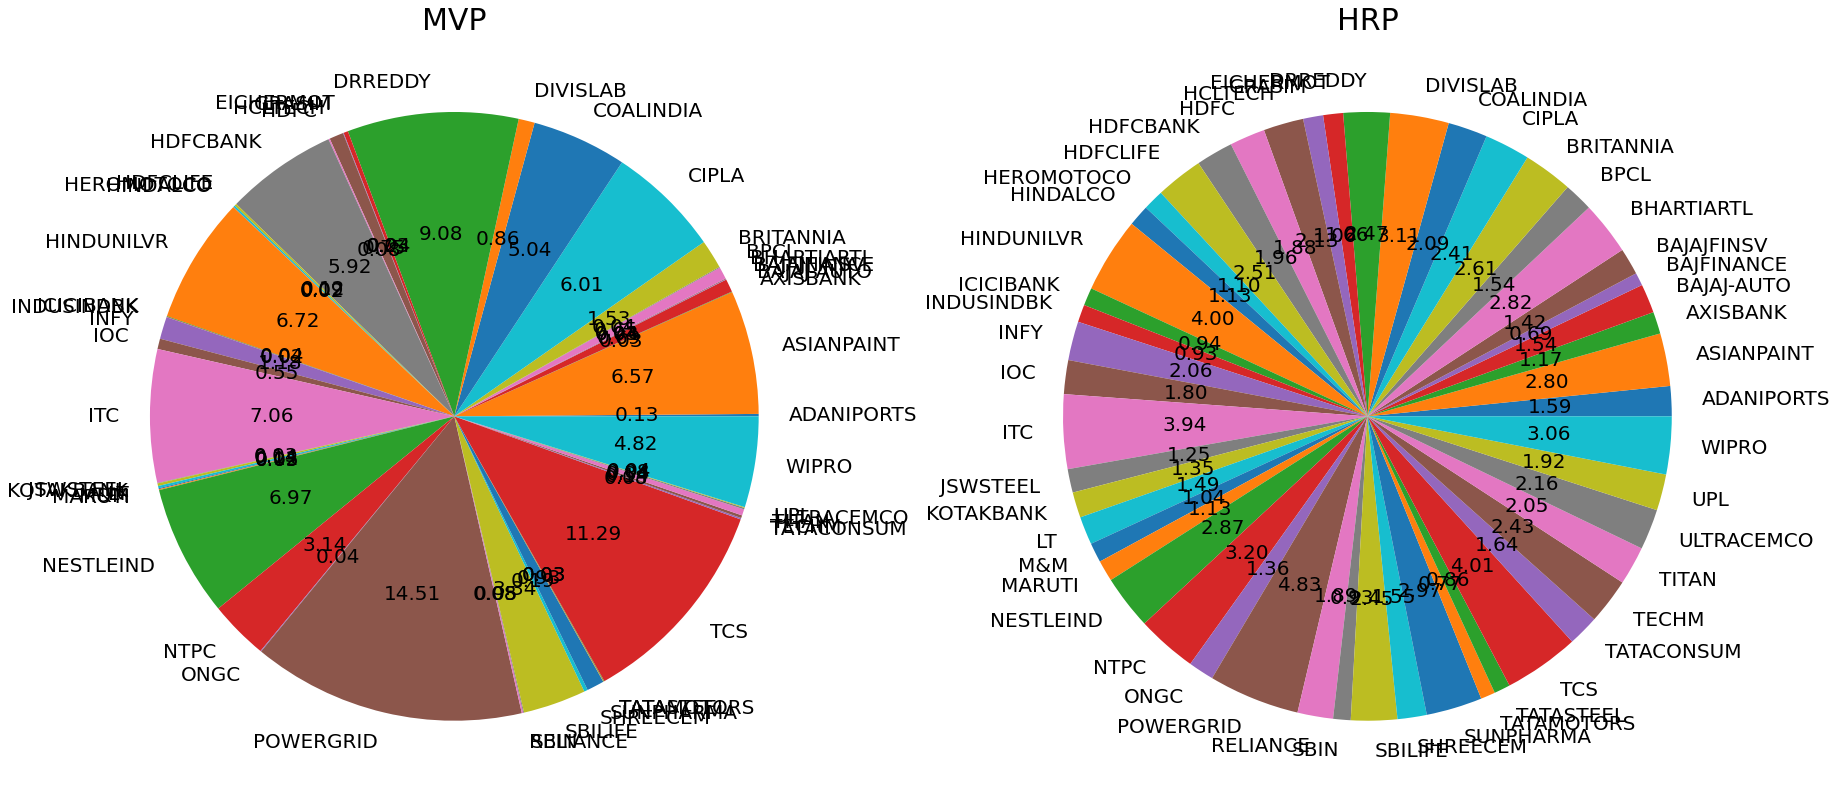

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,20))
ax1.pie(portfolios.iloc[:,0], labels= portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax1.set_title('MVP',fontsize = 30)
ax2.pie(portfolios.iloc[:,1], labels=portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax2.set_title('HRP',fontsize = 30)
#portfolios.plot.pie(subplots=True, figsize=(20, 10),legend = False);

In [29]:
# MVP - Markowitz’s Minimum-Variance Portfolio Weights
portfolios.iloc[:,0]

ADANIPORTS    0.001280
ASIANPAINT    0.065688
AXISBANK      0.000273
BAJAJ-AUTO    0.006925
BAJFINANCE    0.000318
BAJAJFINSV    0.000357
BHARTIARTL    0.006450
BPCL          0.000447
BRITANNIA     0.015312
CIPLA         0.060079
COALINDIA     0.050365
DIVISLAB      0.008565
DRREDDY       0.090809
EICHERMOT     0.002411
GRASIM        0.000321
HCLTECH       0.007519
HDFC          0.000752
HDFCBANK      0.059241
HDFCLIFE      0.001152
HEROMOTOCO    0.000888
HINDALCO      0.000219
HINDUNILVR    0.067221
ICICIBANK     0.000355
INDUSINDBK    0.000219
INFY          0.011781
IOC           0.005523
ITC           0.070645
JSWSTEEL      0.000273
KOTAKBANK     0.001393
LT            0.001191
M&M           0.000539
MARUTI        0.000501
NESTLEIND     0.069745
NTPC          0.031368
ONGC          0.000422
POWERGRID     0.145060
RELIANCE      0.000765
SBIN          0.000462
SBILIFE       0.033428
SHREECEM      0.001905
SUNPHARMA     0.009277
TATAMOTORS    0.000278
TATASTEEL     0.000336
TCS        

In [30]:
# HRP - Hierarchial Risk Parity Portfolio Weights
portfolios.iloc[:,1]

ADANIPORTS    0.015945
ASIANPAINT    0.027972
AXISBANK      0.011698
BAJAJ-AUTO    0.015379
BAJFINANCE    0.006853
BAJAJFINSV    0.014210
BHARTIARTL    0.028246
BPCL          0.015430
BRITANNIA     0.026139
CIPLA         0.024120
COALINDIA     0.020939
DIVISLAB      0.031135
DRREDDY       0.024651
EICHERMOT     0.010565
GRASIM        0.010635
HCLTECH       0.021270
HDFC          0.018846
HDFCBANK      0.019648
HDFCLIFE      0.025079
HEROMOTOCO    0.010995
HINDALCO      0.011261
HINDUNILVR    0.039964
ICICIBANK     0.009448
INDUSINDBK    0.009313
INFY          0.020645
IOC           0.017981
ITC           0.039436
JSWSTEEL      0.012502
KOTAKBANK     0.013548
LT            0.014905
M&M           0.010392
MARUTI        0.011259
NESTLEIND     0.028738
NTPC          0.032039
ONGC          0.013603
POWERGRID     0.048309
RELIANCE      0.018907
SBIN          0.009284
SBILIFE       0.024491
SHREECEM      0.015515
SUNPHARMA     0.029717
TATAMOTORS    0.007716
TATASTEEL     0.008589
TCS        

<a id='5'></a>
## 5. Performance Evaluation of the Portfolios 

### 5.1 Cumulative Returns - Training and Test Data 

In [31]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['MVP', 'HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['MVP', 'HRP'], index = returns_test.index)

<AxesSubplot:xlabel='date', ylabel='Return'>

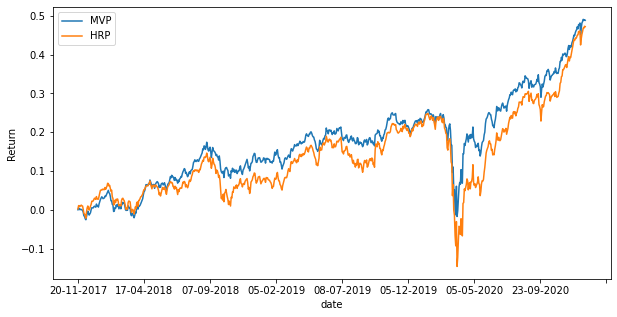

In [32]:
Insample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")
OutOfSample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")

In [33]:
ret_insample=Insample_Result.mean() * 252
ret_insample

MVP    0.160107
HRP    0.154732
dtype: float64

In [34]:
ret_out_of_sample = OutOfSample_Result.mean() * 252
ret_out_of_sample

MVP    0.209467
HRP    0.272897
dtype: float64

###  5.2 Sharpe Ratio and Annual Volatility - Training and Test Data

In [35]:
#In_sample Results
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

stdev  sharp_ratio
MVP  0.158919     1.007476
HRP  0.186945     0.827690

In [36]:
#Outof_sample Results
stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

stdev_oos  sharp_ratio_oos
MVP   0.129923         1.612237
HRP   0.139429         1.957248